In [203]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import *
import math as math 
from numpy.linalg import norm
%matplotlib inline
import matplotlib.pyplot as plt
import datetime

In [204]:
#Train

train = pd.read_csv('train.csv', delimiter=',', index_col='datetime', parse_dates=True)
#train.describe()

train['year'] = train.index.year
train['month'] = train.index.month
train['hour'] = train.index.hour
train['day'] = train.index.weekday

season = train['month']
season = season.apply(lambda s: 4 if int(s) == 1 or int(s) == 2 else (int(s) - 3) // 3 + 1)   
train = train.drop('season', axis = 1)
train.insert(5, 'season', season)

hour = train['hour']
mainHour = np.arange(hour.shape[0])
mainHour = [1 if (hour[i] == 7) or (hour[i] == 8) or (hour[i] == 17) or (hour[i] == 18) else 0 for i in range(hour.shape[0])]
train.insert(6, 'mainHour', mainHour)

train.head(5)

,holiday,workingday,weather,temp,atemp,season,mainHour,humidity,windspeed,casual,registered,count,year,month,hour,day
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,0,1,9.84,14.395,4,0,81,0.0,3,13,16,2011,1,0,5
2011-01-01 01:00:00,0,0,1,9.02,13.635,4,0,80,0.0,8,32,40,2011,1,1,5
2011-01-01 02:00:00,0,0,1,9.02,13.635,4,0,80,0.0,5,27,32,2011,1,2,5
2011-01-01 03:00:00,0,0,1,9.84,14.395,4,0,75,0.0,3,10,13,2011,1,3,5
2011-01-01 04:00:00,0,0,1,9.84,14.395,4,0,75,0.0,0,1,1,2011,1,4,5


In [205]:
#Test
 
test = pd.read_csv('test.csv', delimiter=',', index_col='datetime', parse_dates=True)
#test.describe()

test['year'] = test.index.year
test['month'] = test.index.month
test['hour'] = test.index.hour
test['day'] = test.index.weekday

season = test['month']
season = season.apply(lambda s: 4 if int(s) == 1 or int(s) == 2 else (int(s) - 3) // 3 + 1)   
test = test.drop('season', axis = 1)
test.insert(5, 'season', season)

hour = test['hour']
mainHour = np.arange(hour.shape[0])
mainHour = [1 if (hour[i] == 7) or (hour[i] == 8) or (hour[i] == 17) or (hour[i] == 18) else 0 for i in range(hour.shape[0])]
test.insert(6, 'mainHour', mainHour)

test.head(5)

,holiday,workingday,weather,temp,atemp,season,mainHour,humidity,windspeed,year,month,hour,day
datetime,,,,,,,,,,,,,
2011-01-20 00:00:00,0,1,1,10.66,11.365,4,0,56,26.0027,2011,1,0,3
2011-01-20 01:00:00,0,1,1,10.66,13.635,4,0,56,0.0000,2011,1,1,3
2011-01-20 02:00:00,0,1,1,10.66,13.635,4,0,56,0.0000,2011,1,2,3
2011-01-20 03:00:00,0,1,1,10.66,12.880,4,0,56,11.0014,2011,1,3,3
2011-01-20 04:00:00,0,1,1,10.66,12.880,4,0,56,11.0014,2011,1,4,3


In [206]:
# 0.43532   **2  или *2 все равно, один рез-т
train['hour2'] = (train['hour'])*2
test['hour2'] = (test['hour'])*2

# 0.43756
# train['temp2'] = (train['temp'])**2
# test['temp2'] = (test['temp'])**2

# 0.43538
# train['dif'] = (train['temp'] - train['hour'])**2
# test['dif'] = (test['temp'] - test['hour'])**2

#?
# train['hum2'] = (train['humidity'])*2
# test['hum2'] = (test['humidity'])*2

# 0.43756
# train['dif'] = (train['atemp'] - train['temp'])**2
# test['dif'] = (test['atemp'] - test['temp'])**2

#0.43238
train['dif1'] = (train['windspeed'] - train['atemp'])**2
test['dif1'] = (test['windspeed'] - test['atemp'])**2

# 0.43679
# train['dif2'] = (train['humidity'] - train['windspeed'])**2
# test['dif2'] = (test['humidity'] - test['windspeed'])**2

#0.43814
# train['wd2'] = (train['workingday'])*2
# test['wd2'] = (test['workingday'])*2


X = train.drop(['mainHour', 'casual', 'registered', 'count'], axis = 1)
Xr = train.drop(['casual', 'registered', 'count'], axis = 1)
X_test = test.drop(['mainHour'], axis = 1)
Xr_test = test

In [207]:
maxDepth = 10
nEstimators = 120
subSample = 0.9

y = train['casual']
xgb_model = xgb.XGBRegressor(max_depth = maxDepth, n_estimators = nEstimators, subsample = subSample).fit(X,y)

predictions1 = xgb_model.predict(X)
#-----------------------------------
y = train['registered']
xgb_model = xgb.XGBRegressor(max_depth = maxDepth, n_estimators = nEstimators, subsample = subSample).fit(Xr,y)

predictions2 = xgb_model.predict(Xr)
#-----------------------------------
y = train['count']
predictions = predictions1 + predictions2
predictions = np.round(predictions)

print(min(abs(predictions - y)))
# print(sum(abs(y - predictions)) / len(predictions))
print(math.sqrt(1 / len(y) * sum((np.log(predictions + 1) - np.log(y + 1))**2)))
# print(norm(abs(predictions - y), ord = 2))
print(max(abs(predictions - y)))
print(len([elem for elem in (abs(predictions - y) / y) if elem < 0.1]), train.shape[0])

0.0
0.13421685336008693
76.0
8897 10886


In [208]:
y = np.log(train['casual'] + 1)

xgb_model = xgb.XGBRegressor(max_depth = maxDepth, n_estimators = nEstimators, subsample = subSample).fit(X,y)
predictions1 = np.exp(xgb_model.predict(X_test)) - 1
#--------------------------
y = np.log(train['registered'] + 1)

xgb_model = xgb.XGBRegressor(max_depth = maxDepth, n_estimators = nEstimators, subsample = subSample).fit(Xr,y)
predictions2 = np.exp(xgb_model.predict(Xr_test)) - 1
#--------------------------
predictions = predictions1 + predictions2
predictions = np.round(predictions)
predictions = [0 if predictions[i] < 0.01 else predictions[i] for i in range(predictions.shape[0])]

test.insert(len(test.columns), 'count', predictions)
test.head(10)

,holiday,workingday,weather,temp,atemp,season,mainHour,humidity,windspeed,year,month,hour,day,hour2,dif1,count
datetime,,,,,,,,,,,,,,,,
2011-01-20 00:00:00,0,1,1,10.66,11.365,4,0,56,26.0027,2011,1,0,3,0,214.262261,13.0
2011-01-20 01:00:00,0,1,1,10.66,13.635,4,0,56,0.0000,2011,1,1,3,2,185.913225,5.0
2011-01-20 02:00:00,0,1,1,10.66,13.635,4,0,56,0.0000,2011,1,2,3,4,185.913225,3.0
2011-01-20 03:00:00,0,1,1,10.66,12.880,4,0,56,11.0014,2011,1,3,3,6,3.529138,2.0
2011-01-20 04:00:00,0,1,1,10.66,12.880,4,0,56,11.0014,2011,1,4,3,8,3.529138,2.0
2011-01-20 05:00:00,0,1,1,9.84,11.365,4,0,60,15.0013,2011,1,5,3,10,13.222678,6.0
2011-01-20 06:00:00,0,1,1,9.02,10.605,4,0,60,15.0013,2011,1,6,3,12,19.327454,34.0
2011-01-20 07:00:00,0,1,1,9.02,10.605,4,1,55,15.0013,2011,1,7,3,14,19.327454,86.0
2011-01-20 08:00:00,0,1,1,9.02,10.605,4,1,55,19.0012,2011,1,8,3,16,70.496174,201.0


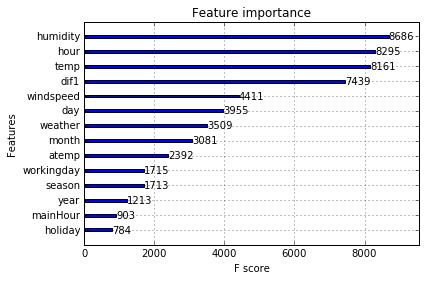

In [209]:
xgb.plot_importance(xgb_model)

In [210]:
newny = pd.DataFrame(test.index)
newny.insert(1, 'count', predictions)
newny.head(20)

newny.to_csv('submission.csv', sep=',', header = True, index = False)